In [17]:
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np

In [2]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    # First convolution
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='valid')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the shortcut to the output
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

In [3]:
def create_resnet_model(input_shape=(224, 224, 3), num_classes=1000, num_blocks=[2, 2, 2, 2]):
    input_layer = layers.Input(shape=input_shape)

    # Initial convolution
    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Residual Blocks
    filters = 64
    for num_blocks_in_stage in num_blocks:
        for _ in range(num_blocks_in_stage):
            x = residual_block(x, filters)
        filters *= 2

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x)
    return model

In [4]:
# Create a ResNet model
resnet_model = create_resnet_model()
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [5]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
# Normalize images to the range [-1, 1]
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_test = (x_test.astype(np.float32) - 127.5) / 127.5

In [7]:
# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [8]:
# Create ResNet model
resnet_model = create_resnet_model(input_shape=(32, 32, 3), num_classes=10)

In [9]:
# Compile the model
resnet_model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Data augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(x_train)

In [14]:
# Training the model
batch_size = 64
epochs = 10

In [12]:
# Checkpoint to save the best model during training
checkpoint = ModelCheckpoint('resnet_cifar10.h5', save_best_only=True)

In [15]:
# Fit the model
history = resnet_model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                            validation_data=(x_test, y_test), callbacks=[checkpoint])

Epoch 1/10
782/781 [==============================] - ETA: -1s - loss: 1.4642 - accuracy: 0.4766

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


781/781 [==============================] - 1875s 2s/step - loss: 1.4642 - accuracy: 0.4766 - val_loss: 1.3244 - val_accuracy: 0.5384
Epoch 2/10
781/781 [==============================] - 1718s 2s/step - loss: 1.0342 - accuracy: 0.6349 - val_loss: 1.1233 - val_accuracy: 0.6245
Epoch 3/10
781/781 [==============================] - 1869s 2s/step - loss: 0.8666 - accuracy: 0.6958 - val_loss: 0.9042 - val_accuracy: 0.7020
Epoch 4/10
781/781 [==============================] - 1864s 2s/step - loss: 0.7672 - accuracy: 0.7320 - val_loss: 0.9391 - val_accuracy: 0.6890
Epoch 5/10
781/781 [==============================] - 1836s 2s/step - loss: 0.6920 - accuracy: 0.7586 - val_loss: 0.8851 - val_accuracy: 0.7098
Epoch 6/10
781/781 [==============================] - 1718s 2s/step - loss: 0.6321 - accuracy: 0.7790 - val_loss: 0.6564 - val_accuracy: 0.7790
Epoch 7/10
781/781 [==============================] - 1760s 2s/step - loss: 0.5875 - accuracy: 0.7966 - val_loss: 0.7597 - val_accuracy: 0.7428
Epo

In [16]:
# Evaluate the model
score = resnet_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6229200959205627
Test accuracy: 0.7925000190734863


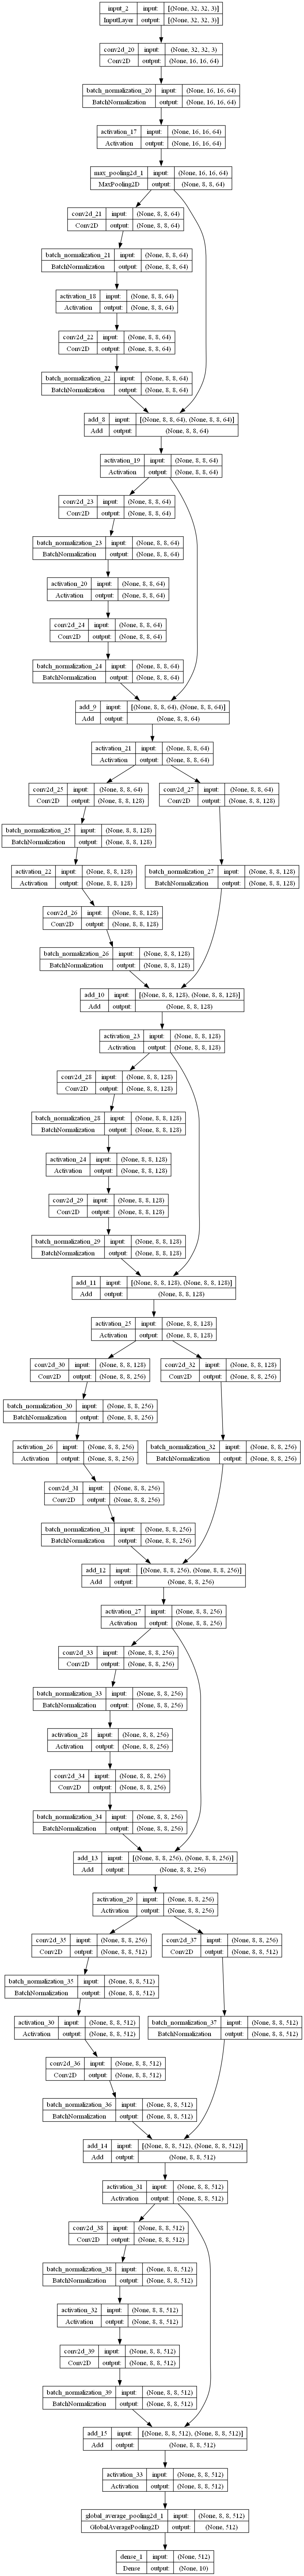

In [18]:
# Plot model architecture
tf.keras.utils.plot_model(resnet_model, show_shapes=True, to_file='ResNet_model.png')